In [ ]:
#@title Corre Tensorflow
%tensorflow_version 2.x

In [ ]:
#@title Bibliotecas

import numpy as np
import pandas as pd
import math
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import scipy 
from scipy import fftpack
from sklearn.linear_model import LogisticRegression # for Logistic Regression Algorithm
from sklearn.model_selection import train_test_split # to split the dataset for training and testing 
from sklearn.neighbors import KNeighborsClassifier # KNN classifier
from sklearn import svm # for suport vector machine algorithm
from sklearn import metrics # for checking the model accuracy
from sklearn import preprocessing # for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier # for using DTA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from scipy import signal

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Bibliotecas Importadas")

Bibliotecas Importadas


1000000


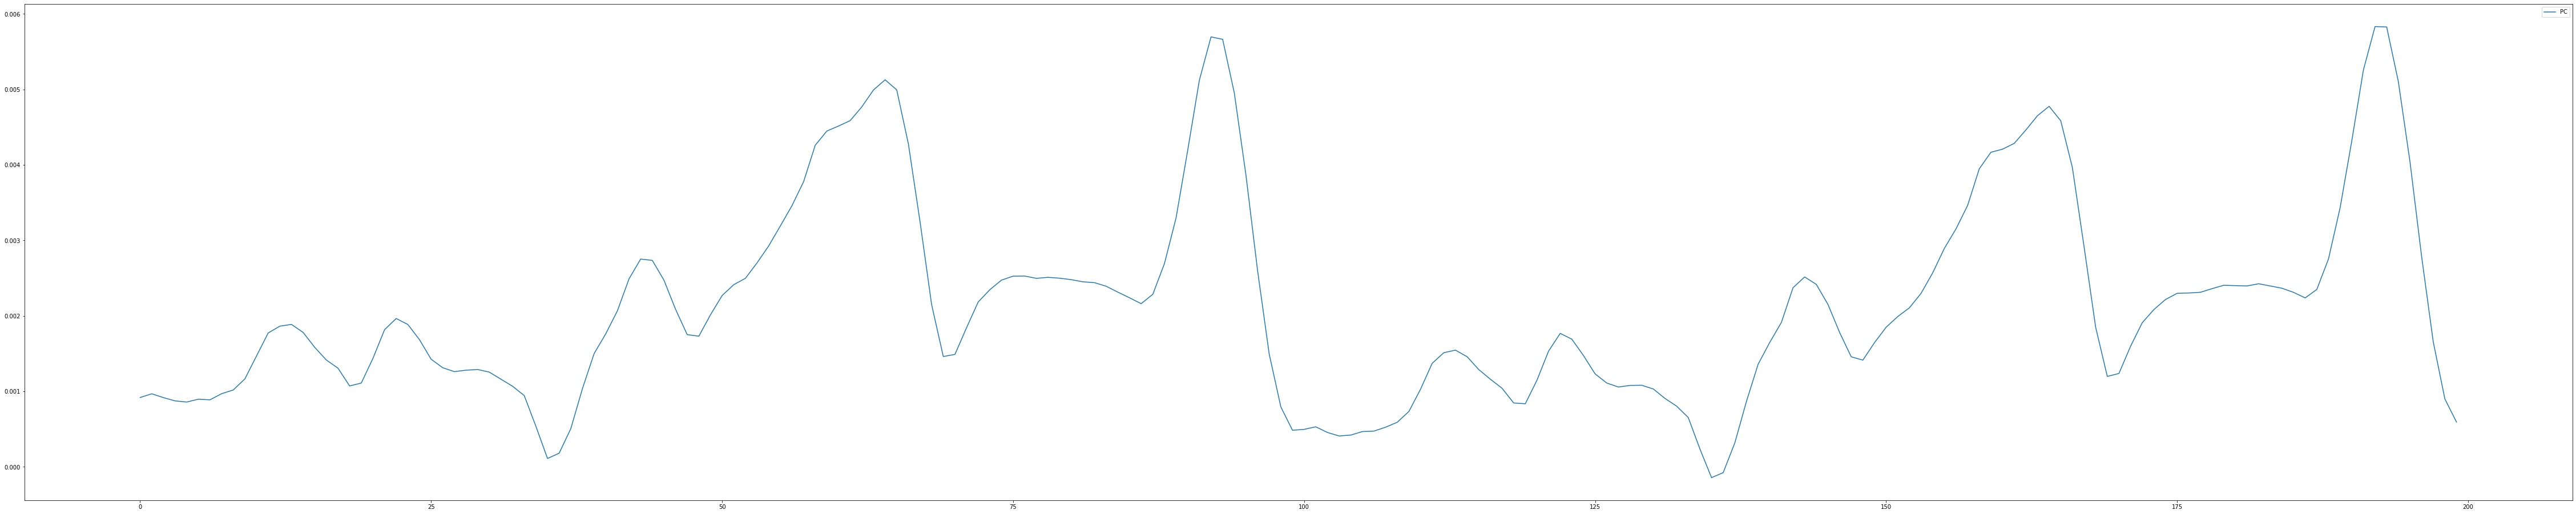

In [ ]:
#@title PC
pd.options.display.float_format = '{:,.8f}'.format
#reading csv
pc=pd.read_csv("/content/drive/My Drive/Tese/Dados/atmegapc.csv", sep=',',  header=None, names=["Tempo", "PC"],skiprows=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
tempo=pc["Tempo"]
pc=scipy.signal.savgol_filter(pc['PC'].values, 953, 3)
pc=pd.DataFrame(pc)
pc.columns=["PC"]
pc["Tempo"]=tempo
#pc.iloc[:5000,:].plot(figsize=(40,8),y="PC")
#ir.iloc[:5000,:].plot(figsize=(40,8),y="PC")


len_pc = len(pc.index)#number of samples

freq_pc = 20e9 #sampling frequency 

freqinst_pc = 4e6  #instruction frequency 

T_pc = 1/freq_pc #time period

Tinst_pc= 1/freqinst_pc #instruction time period


t=pc["Tempo"].values
f=pc["PC"].values

fhat=np.fft.fft(f,n=12500000)

f_downsample=np.fft.ifft(fhat,1000000)

pc_resample=pd.DataFrame(f_downsample.real)

pc_resample.columns=["PC"]


print(len(pc_resample["PC"].index))


pc_resample = pc_resample.drop(pc_resample[pc_resample.index < 60].index)
pc_resample.reset_index(drop=True, inplace=True)

pc_resample.iloc[:200,:].plot(figsize=(80,16),y="PC")


pc_resample = pc_resample.drop(pc_resample[pc_resample.index > 820800].index)
pc_resample.reset_index(drop=True, inplace=True)

pcmean=pc_resample.groupby(pc_resample.index//100).mean()

#scaler = MinMaxScaler()
#pc_norm = scaler.fit_transform(pcmean)
#pcmean=pd.DataFrame(pc_norm, index=pcmean.index, columns=pcmean.columns)

#pcmean.iloc[:400,:].plot.bar(figsize=(80,16),y="PC")


In [ ]:
#@title S calculator
def s_calculator(signal_2, n_inst_2, num_2, inst_per_period_2, changes_2):
  dataframe_array={}
  print(signal_2)
  offset=(signal_2.iloc[:,0].idxmin(1)%1026)
  signal_2=pd.DataFrame(signal_2).copy()
  signal_2["Indice"]=(signal_2.index-offset)%1026
  signal_2["Indice_Reor"]=(signal_2.index)
  dataframe_array=signal_2.copy()
  dataframe_array=pd.DataFrame.sort_values(dataframe_array,"Indice",ignore_index=True)
  
  last_2=0
  next_2=0
  pc_i=0
  ir=0
  for x in dataframe_array.index:
    if (pc_i>1025):
      pc_i=0
    if (x%2==0 and x>=1):
      ir=ir+1
    dataframe_array.loc[x,"HDPC"]=(bin((pc_i)^(pc_i+1)).count('1'))
    dataframe_array.loc[x,"HDIR"]=(ir%15)
    pc_i=pc_i+1

  #dataframe_array=pd.DataFrame.sort_values(dataframe_array,"Indice_Reor",ignore_index=True)

  return dataframe_array

In [ ]:
#@title S calculator
def s2_calculator(signal_2, n_inst_2, num_2, inst_per_period_2, changes_2):
  dataframe_array={}
  print(signal_2)
  offset=(signal_2.iloc[:,0].idxmin(1)%1026)
  signal_2=pd.DataFrame(signal_2).copy()
  signal_2["Indice"]=(signal_2.index-offset)%1026
  signal_2["Indice_Reor"]=(signal_2.index)
  dataframe_array=signal_2.copy()
  dataframe_array=pd.DataFrame.sort_values(dataframe_array,"Indice",ignore_index=True)
  
  last_2=0
  next_2=0
  pc_i=0
  ir=0
  states={1:1, 2:2, 3:14,4:13,5:6, 6:7, 7:8, 8:9,9:10,10:11,11:12, 12:3, 13:4, 14:5,15:15}



  for x in dataframe_array.index:
    if (pc_i>1025):
      pc_i=0
    dataframe_array.loc[x,"HDPC"]=(bin((pc_i)^(pc_i+1)).count('1'))
    dataframe_array.loc[x,"HDIR"]=states.get((x%15)+1)-1
    pc_i=pc_i+1

  #dataframe_array=pd.DataFrame.sort_values(dataframe_array,"Indice_Reor",ignore_index=True)

  return dataframe_array

In [ ]:
#@title WP Subtractor

def wp_sub(u1,u2,size):
  for x in range(size):
    u2[x]=u2[x]-u1[0]
  return u2

In [ ]:
#@title WP Calculator
def wp_calculator(u,changes):
  wp=[0 for x in range(changes)]

  for x in range(changes):
    wp[x]=u[x]-u[0]
  plt.plot(wp)
  return wp

In [ ]:
#@title WP IR Subtractor

def irwp_calculator(u,changes):
  wp=[0 for x in range(changes)]

  for x in range(15):
    wp[x]=u[x]-u[0]
  plt.plot(wp)
  return wp

In [ ]:
#@title HD(PC) cycle
def hd_pc(inst_per_period, changes):
  pc_i_total=[]
  pc_i=0
  for x in range(inst_per_period):
    if (pc_i>1025):
      pc_i=0
    pc_i_total.append(bin((pc_i)^(pc_i+1)).count('1'))
    pc_i=pc_i+1
  #for pc_i in range(inst_per_period):
   #  pc_i_total.append(bin((pc_i)^(pc_i+1)).count('1'))

  w = changes;
  n_i = [0 for x in range(w)] 
  for x in range(changes):
    n_i[x]=(pc_i_total.count(x+1))
  return n_i

In [ ]:
#@title HD(S) cycle
def hd_sig(inst_per_period, changes):
  pc_i_total=[]
  pc_i=0
  for x in range(inst_per_period):
    pc_i_total.append(x%1026)
    #for pc_i in range(inst_per_period):
   #  pc_i_total.append(bin((pc_i)^(pc_i+1)).count('1'))

  w = changes;
  n_i = [0 for x in range(w)] 
  for x in range(changes):
    n_i[x]=(pc_i_total.count(x))
  return n_i

In [ ]:
#@title HD(IR) cycle
def hd_ir(inst_per_period, changes, cpi):
  pc_i_total=[]
  pc_i=0
  for x in range(inst_per_period):
      if (pc_i>1025):
        pc_i=0
      if(int(x%cpi)==0 and x>=1): #cpi
        pc_i=pc_i+1
      #print(ir)
      pc_i_total.append(int((pc_i)%15))
  #for pc_i in range(inst_per_period):
   #  pc_i_total.append(bin((pc_i)^(pc_i+1)).count('1'))

  w = changes;
  n_i = [0 for x in range(w)] 
  for x in range(changes):
    n_i[x]=(pc_i_total.count(x))
  return n_i

In [ ]:
#@title PC Background Calculator

def background_calc(signal, n_inst, num, inst_per_period, changes):
  w, h = num, inst_per_period;
  #offset=(signal.iloc[:,0].idxmin(1)%1026)

  dados = {}
  for x in range(num):
  #  pcmean_min=pcmean.groupby(pcmean.index//1026)['PC'].nsmallest(512,'all').mean(level=0)
    dados[x]=pd.DataFrame(((signal.iloc[(x*inst_per_period):((x+1)*inst_per_period)])).values)
    #print(dados[x].iloc[:,0].idxmin(1))
    #print(dados[x].iloc[:,0])
    #dados[x]["Indice"]=pd.DataFrame(((dados[x].index-offset)%1026).values)
    #dados[x]["Indice_Reor"]=pd.DataFrame((dados[x].index))
    #print(dados[x])
    #dados[x]=pd.DataFrame.sort_values(dados[x],"Indice",ignore_index=True)
    #print(dados[x])
  pc_i=0
  for i in range(num):
    for x in dados[i].index:
      if (pc_i>1025):
        pc_i=0
      dados[i].loc[x,"HDPC"]=(bin((pc_i)^(pc_i+1)).count('1'))
      pc_i=pc_i+1  
      #dados[x]=sorted(dados[x],key=float)
    print(i)
    dados[i]=pd.DataFrame.sort_values(dados[i],"HDPC",ignore_index=True)

  w = changes;
  last=0
  next=0
  u = [0 for x in range(w)] 
  for y in range (changes):
    last=next
    next=next+n_inst[y]
    print(n_inst[y])
    for x in range(num):
      u[y]=(u[y]+((sum(dados[x].iloc[last:next,0])) / len(dados[x].iloc[last:next,0].index)))
    u[y]=u[y]/num
  return u

In [ ]:
def hdpc_calc(signal, n_inst, num, inst_per_period, changes):
  w, h = num, inst_per_period;
  signal_c=pd.DataFrame(signal.copy())
  pc_i=0
  for x in signal_c.index:
    if (pc_i>1025):
      pc_i=0
    signal_c.loc[x,"HDPC"]=(bin((pc_i)^(pc_i+1)).count('1'))%11      
    pc_i=pc_i+1  
      #dados[x]=sorted(dados[x],key=float)
  print(signal)
  #signal_c=pd.DataFrame.sort_values(signal,"HDPC",ignore_index=True)
  return signal_c


In [ ]:
#@title Signal Background Calculator

def signal_background_calc(signal, n_inst, num, inst_per_period, changes):
  w, h = num, inst_per_period;
  #offset=(signal.iloc[:,0].idxmin(1)%1026)

  dados = {}
  for x in range(num):
  #  pcmean_min=pcmean.groupby(pcmean.index//1026)['PC'].nsmallest(512,'all').mean(level=0)
    dados[x]=pd.DataFrame(((signal.iloc[(x*inst_per_period):((x+1)*inst_per_period)])).values)
    #print(dados[x].iloc[:,0].idxmin(1))
    #print(dados[x].iloc[:,0])
    #dados[x]["Indice"]=pd.DataFrame(((dados[x].index-offset)%1026).values)
    #dados[x]["Indice_Reor"]=pd.DataFrame((dados[x].index))
    #print(dados[x])
    #dados[x]=pd.DataFrame.sort_values(dados[x],"Indice",ignore_index=True)
    #print(dados[x])
  pc_i=0
  for i in range(num):
    for x in dados[i].index:
      print(x)
      dados[i].loc[x,"HDS"]=x%1026
      #dados[x]=sorted(dados[x],key=float)
    dados[i]=pd.DataFrame.sort_values(dados[i],"HDS",ignore_index=True)

  w = changes;
  last=0
  next=0
  u = [0 for x in range(w)] 
  for y in range (changes-1):
    last=next
    next=next+n_inst[y]
    for x in range(num):
      u[y]=(u[y]+((sum(dados[x].iloc[last:next,0])) / len(dados[x].iloc[last:next,0].index)))
    u[y]=u[y]/num
  return u

In [ ]:
#@title IR Background Calculator

def irbackground_calc(signal, n_inst, num, inst_per_period, changes):
  w, h = num, inst_per_period;
  #offset=(signal.iloc[:,0].idxmin(1)%1026)

  dados = {}
  for x in range(num):
  #  pcmean_min=pcmean.groupby(pcmean.index//1026)['PC'].nsmallest(512,'all').mean(level=0)
    dados[x]=pd.DataFrame(((signal.iloc[(x*inst_per_period):((x+1)*inst_per_period)])).values)
    #print(dados[x].iloc[:,0].idxmin(1))
    #print(dados[x].iloc[:,0])
    #dados[x]["Indice"]=pd.DataFrame(((dados[x].index-offset)%1026).values)
    #dados[x]["Indice_Reor"]=pd.DataFrame((dados[x].index))
    #print(dados[x])
    #dados[x]=pd.DataFrame.sort_values(dados[x],"Indice",ignore_index=True)
    #print(dados[x])
  pc_i=0
  ir=0
  for i in range(num):
    for x in dados[i].index:
      if(int(x%2)==0 and x>=1): #cpi
        ir=ir+1
      #print(ir)
      dados[i].loc[x,"HDIR"]=int((ir)%15)
      #dados[i].loc[x,"HDPC"]=(bin((pc_i)^(pc_i+1)).count('1'))
      #pc_i=pc_i+1  
      #dados[x]=sorted(dados[x],key=float)
    #print(dados[0]["HDIR"])
    dados[i]=pd.DataFrame.sort_values(dados[i],"HDIR",ignore_index=True)
  w = changes;
  last=0
  next=0
  u = [0 for x in range(w)] 
  for y in range (changes):
    last=next
    next=next+n_inst[y]
    for x in range(num):
      u[y]=(u[y]+((sum(dados[x].iloc[last:next,0])) / len(dados[x].iloc[last:next,0].index)))
    u[y]=u[y]/num
  return u

0
1
2
3
4
5
6
7
513
257
128
64
32
16
8
4
2
1
1
             PC
0    0.00224856
1    0.00203102
2    0.00220726
3    0.00222051
4    0.00213628
...         ...
8203 0.00101041
8204 0.00101039
8205 0.00101038
8206 0.00101037
8207 0.00101037

[8208 rows x 1 columns]


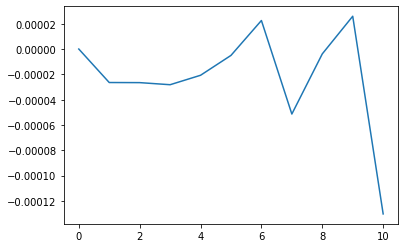

In [ ]:
#@title PC Characterization
sig_x=pcmean.iloc[0:8208,:]
hdpc = [0 for x in range(11)] 
hdpc=hd_pc(1026,11)
u_pc = [0 for x in range(11)] 
u_pc=background_calc(sig_x, hdpc, 8, 1026, 11)
sig_x_pc=(hdpc_calc(sig_x, hdpc, 8, 1026, 11)).copy()
wp_pc=[0 for x in range(11)]
wp_pc=wp_calculator(u_pc,11)


1000000
8208
             IR  Indice
0    0.00206376       0
1    0.00249313       0
2    0.00234082       0
3    0.00256274       0
4    0.00240645       0
...         ...     ...
8204 0.00203232    1025
8205 0.00196476    1025
8206 0.00185503    1025
8207 0.00243433    1025
8208 0.00206309    1025

[8209 rows x 2 columns]
             IR  Indice
0    0.00206376       0
1    0.00249313       0
2    0.00234082       0
3    0.00256274       0
4    0.00240645       0
...         ...     ...
8204 0.00203232    1025
8205 0.00196476    1025
8206 0.00185503    1025
8207 0.00243433    1025
8208 0.00206309    1025

[8209 rows x 2 columns]
              IR  Indice
0    -0.00018981       0
1     0.00023956       0
2     0.00008726       0
3     0.00030917       0
4     0.00015288       0
...          ...     ...
8204 -0.00022125    1025
8205 -0.00028880    1025
8206 -0.00039854    1025
8207  0.00018076    1025
8208 -0.00019048    1025

[8209 rows x 2 columns]
             IR  Indice
0    0.00206

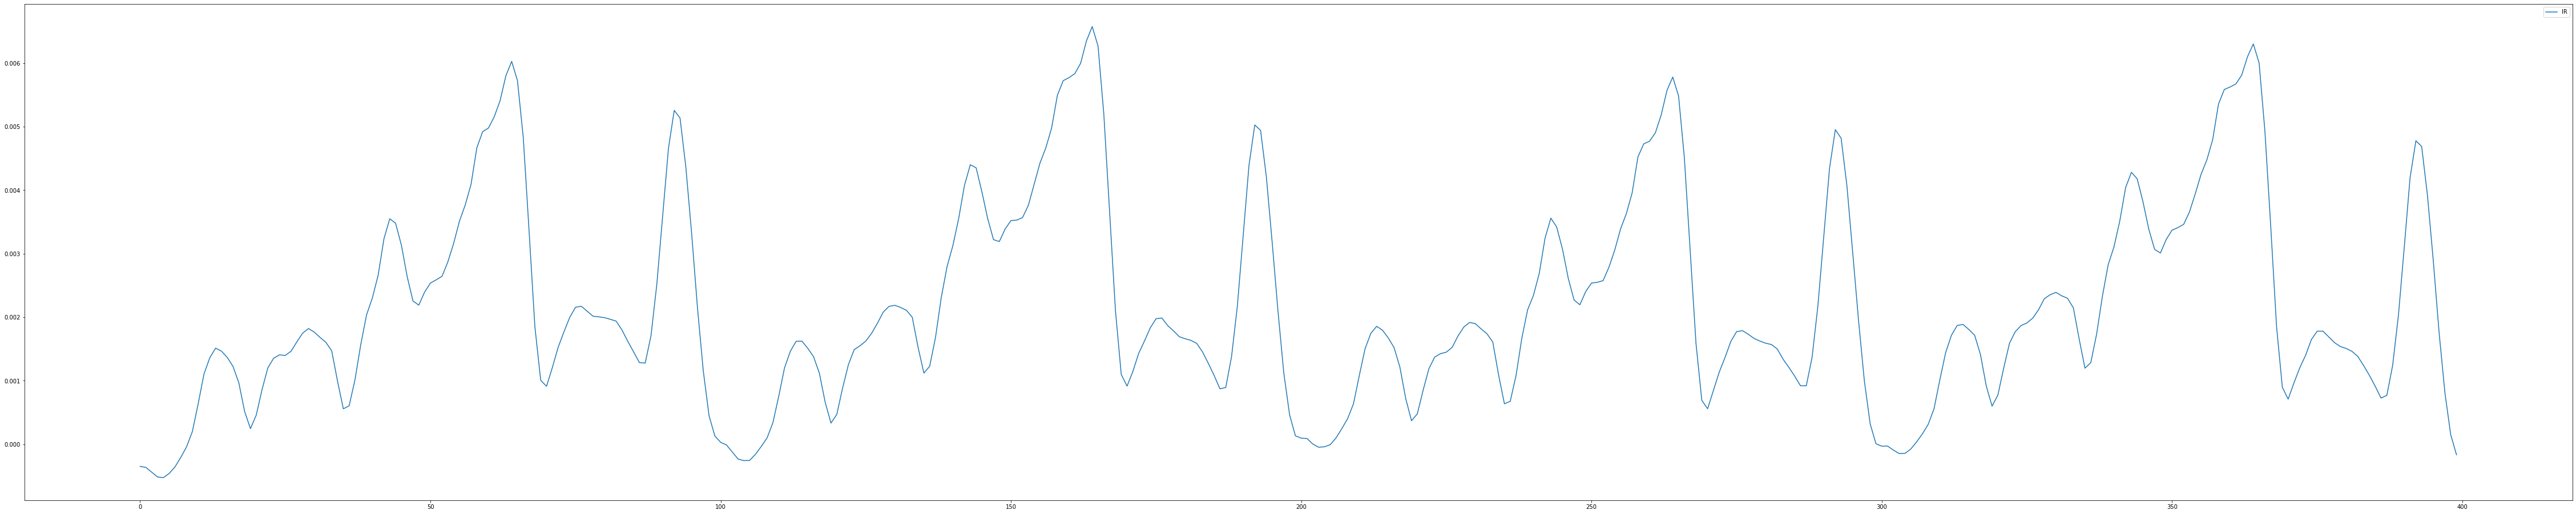

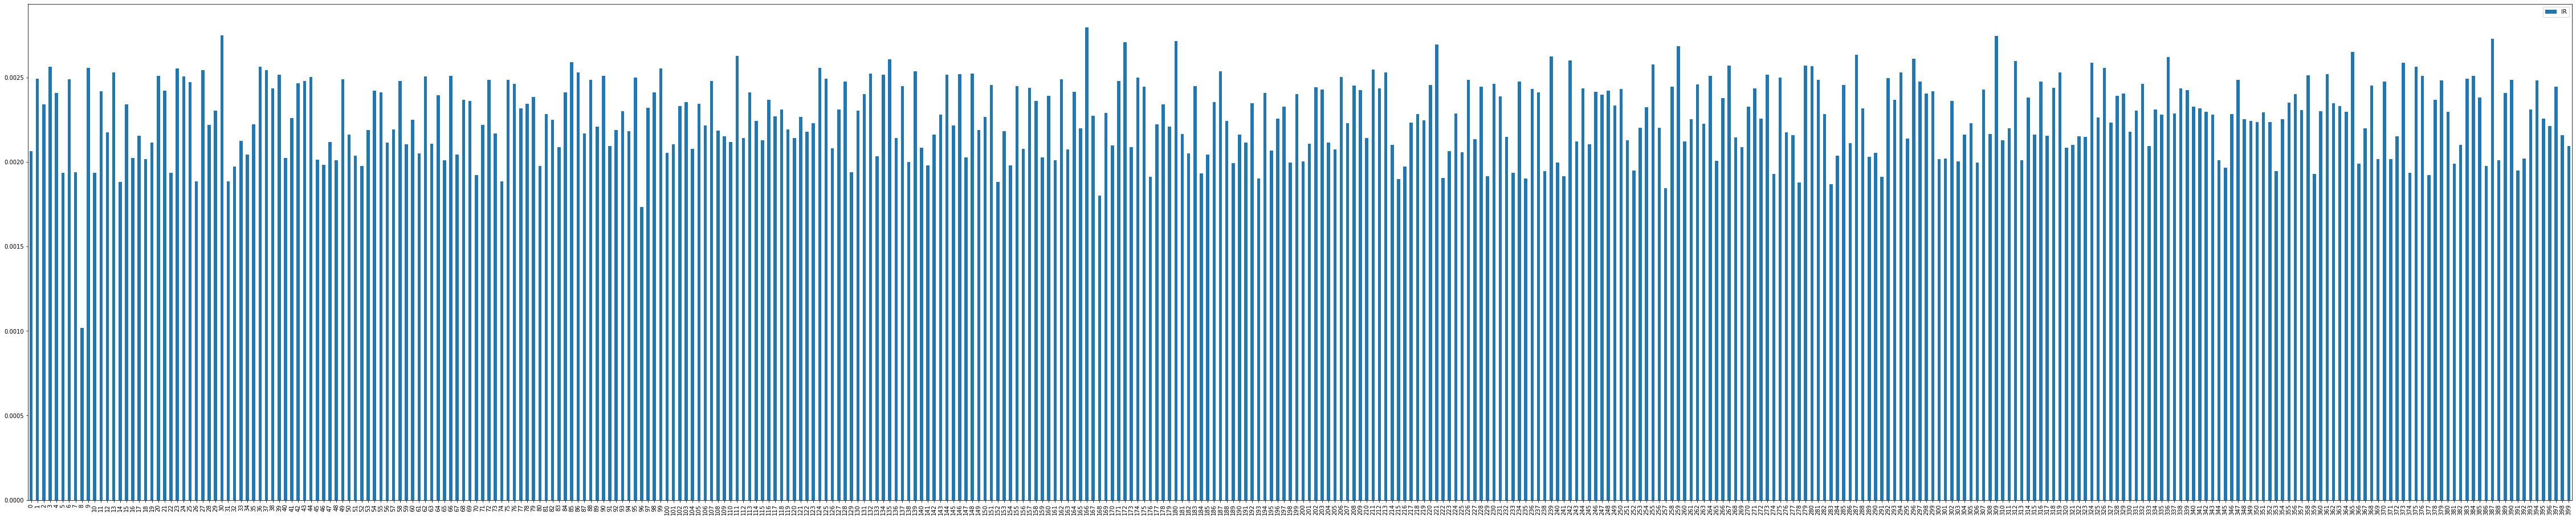

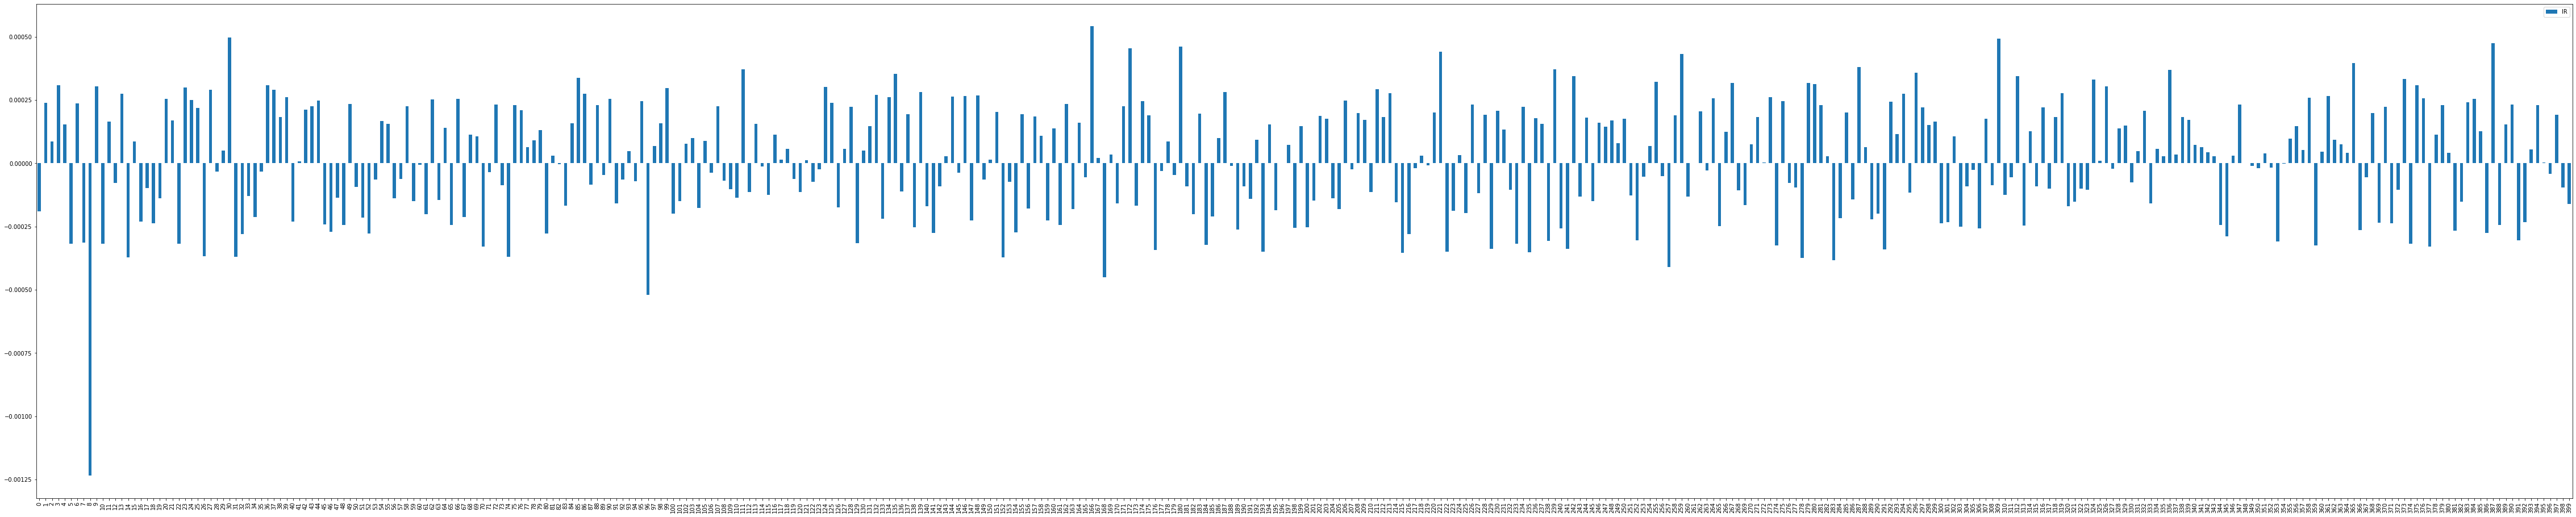

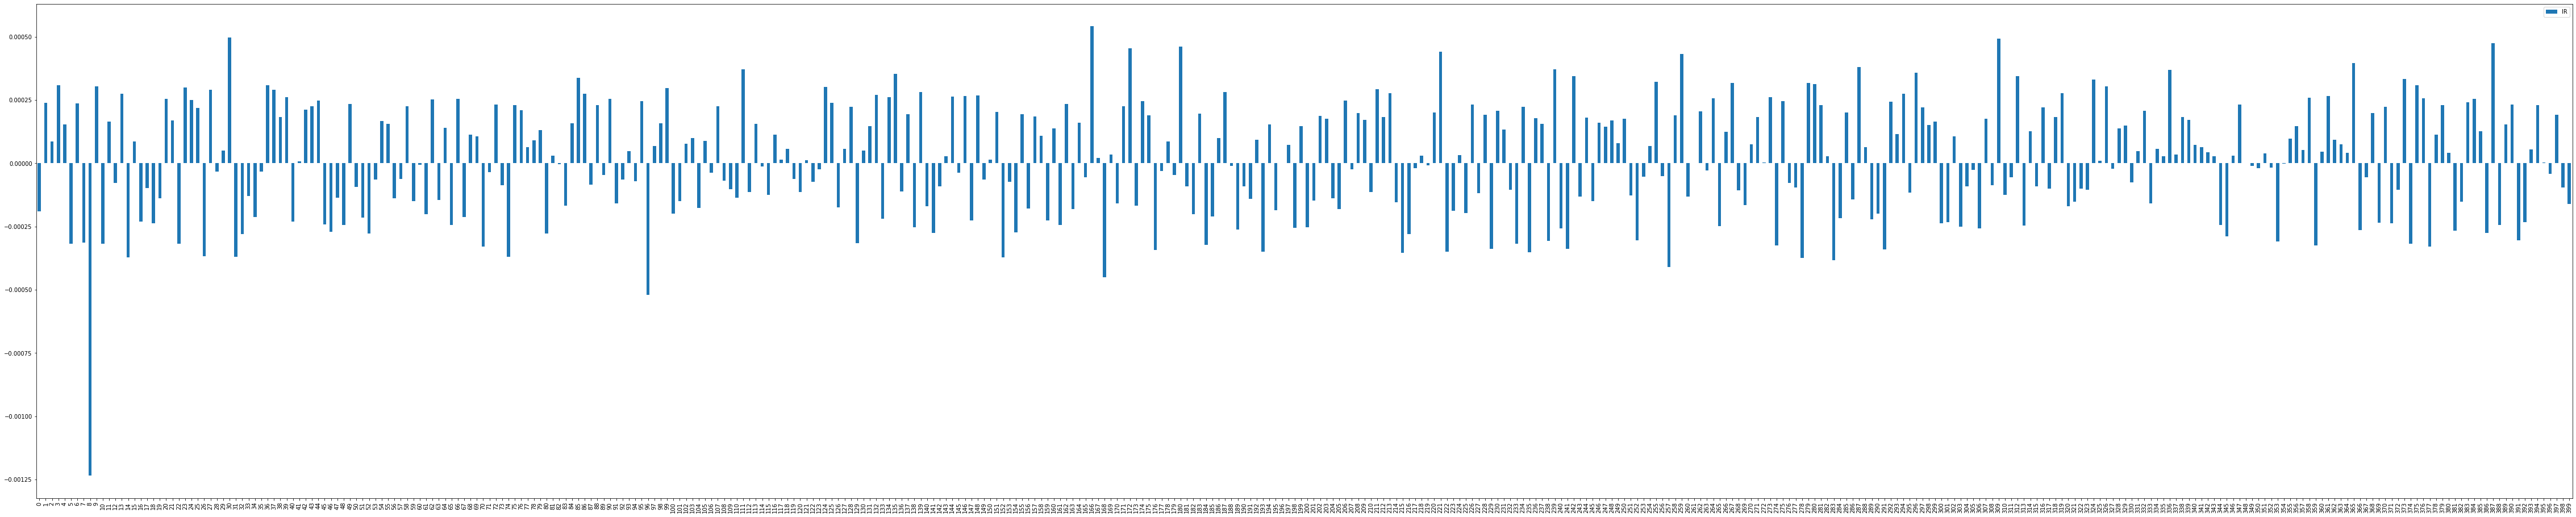

In [ ]:
#@title IR

ir=pd.read_csv("/content/drive/My Drive/Tese/Dados/atmegair.csv", sep=',',  header=None, names=["Tempo", "IR"],skiprows=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
tempo=ir["Tempo"]
ir=scipy.signal.savgol_filter(ir['IR'].values, 953, 3)
ir=pd.DataFrame(ir)
ir.columns=["IR"]
ir["Tempo"]=tempo
#ir.iloc[:5000,:].plot(figsize=(40,8),y="IR")
#ir.iloc[:5000,:].plot(figsize=(40,8),y="IR")


len_ir = len(ir.index)#number of samples

freq_ir = 20e9 #sampling frequency 

freqinst_ir = 4e6  #instruction frequency 

T_ir = 1/freq_ir #time period

Tinst_ir= 1/freqinst_ir #instruction time period


t=ir["Tempo"].values
f=ir["IR"].values

fhat=np.fft.fft(f,n=12500000)

f_downsample=np.fft.ifft(fhat,1000000)

ir_resample=pd.DataFrame(f_downsample.real)

ir_resample.columns=["IR"]


print(len(ir_resample["IR"].index))


ir_resample = ir_resample.drop(ir_resample[ir_resample.index < 60].index)
ir_resample.reset_index(drop=True, inplace=True)

ir_resample.iloc[:400,:].plot(figsize=(80,16),y="IR")


ir_resample = ir_resample.drop(ir_resample[ir_resample.index > 820800].index)
ir_resample.reset_index(drop=True, inplace=True)

irmean=ir_resample.groupby(ir_resample.index//100).mean()

#scaler = MinMaxScaler()
#ir_norm = scaler.fit_transform(irmean)
#irmean=pd.DataFrame(ir_norm, index=irmean.index, columns=irmean.columns)

offset=(irmean.iloc[:,0].idxmin(1))
print(offset)
irmean["Indice"]=pd.DataFrame(((irmean.index-offset)%1026).values)
irmean=pd.DataFrame.sort_values(irmean,"Indice",ignore_index=True)
irmeanir=pd.DataFrame(irmean).copy()
irmeanpc=pd.DataFrame(irmean).copy()
irmean=pd.DataFrame(irmean).copy()
print(irmeanpc)
irmeanpc["IR"]=irmeanpc["IR"]-u_pc[0]

print( irmean)
print( irmeanpc)
print( irmeanir)


for x in irmeanir.index:
  pc_index=(bin((x)^(x+1)).count('1'))%11
  irmeanir.iloc[x,0]=irmeanir.iloc[x,0]-u_pc[0]

irmean.iloc[:400,:].plot.bar(figsize=(80,16),y="IR")
irmeanpc.iloc[:400,:].plot.bar(figsize=(80,16),y="IR")
irmeanir.iloc[:400,:].plot.bar(figsize=(80,16),y="IR")

1000000
8208


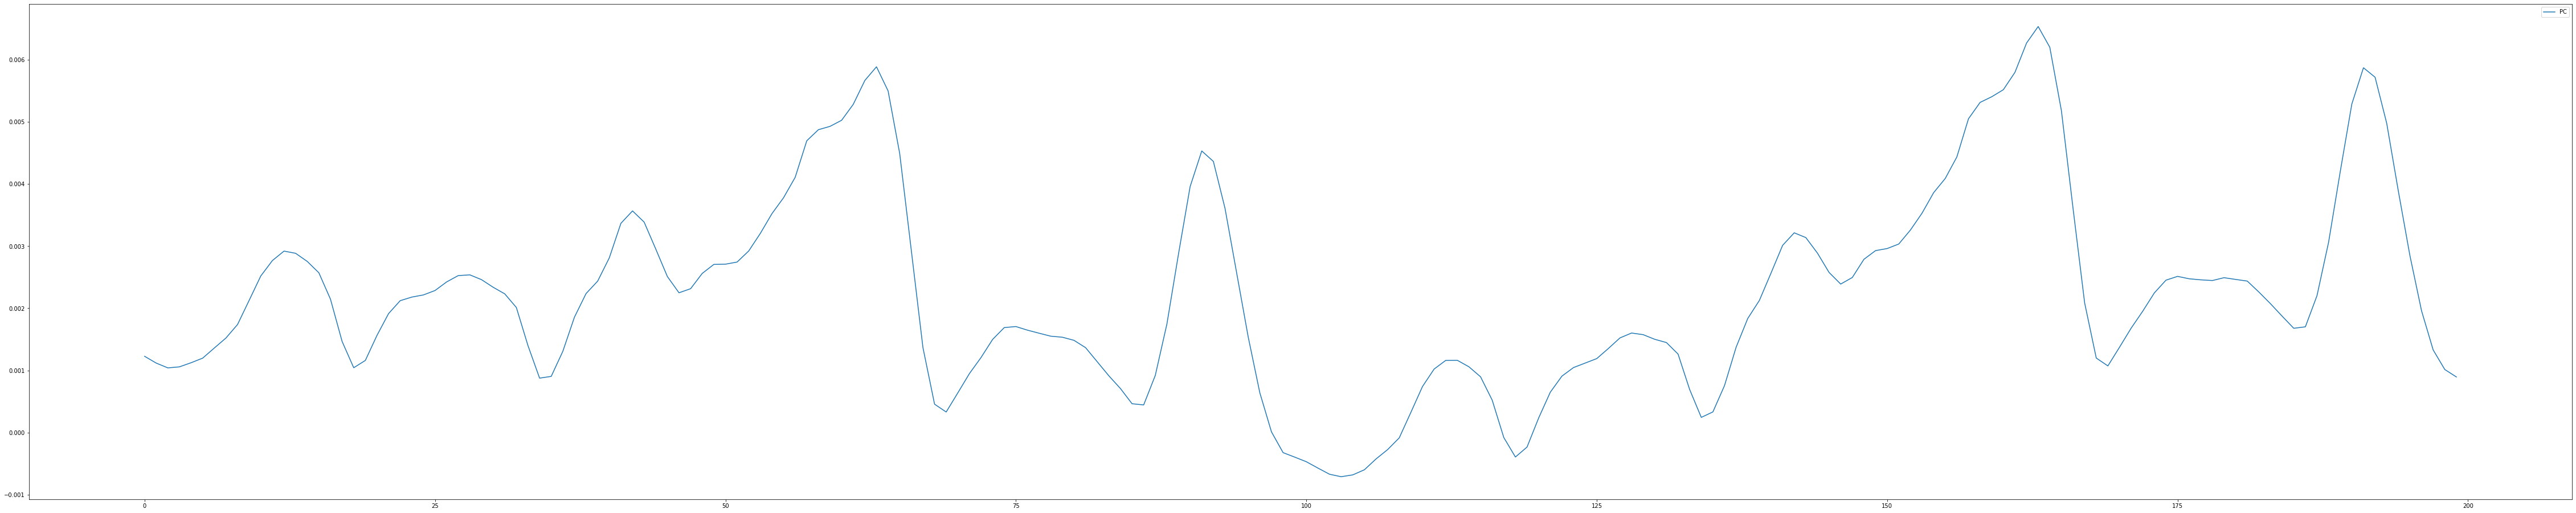

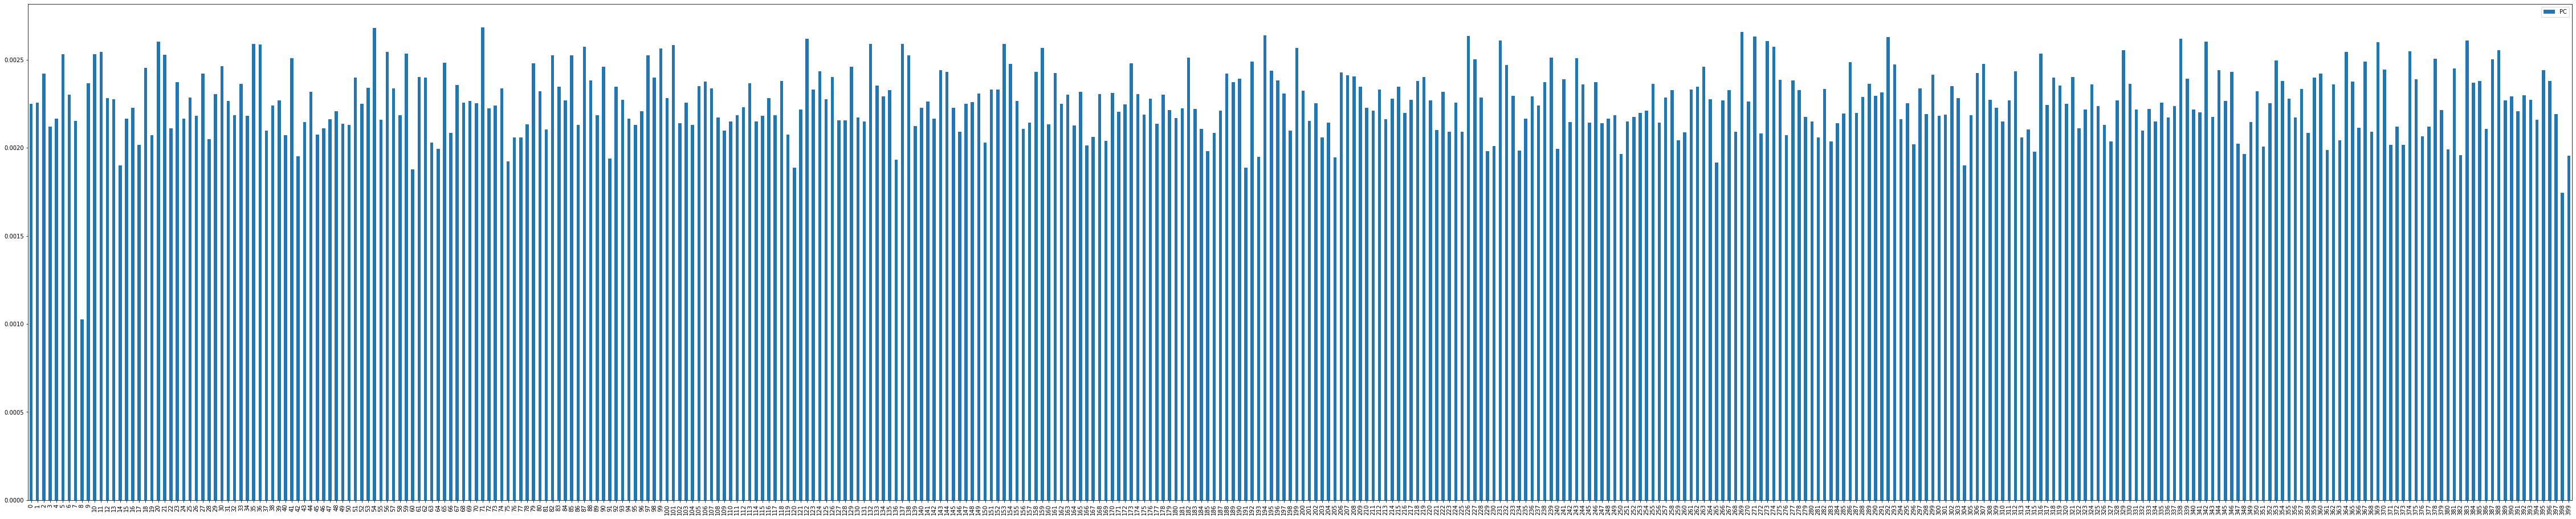

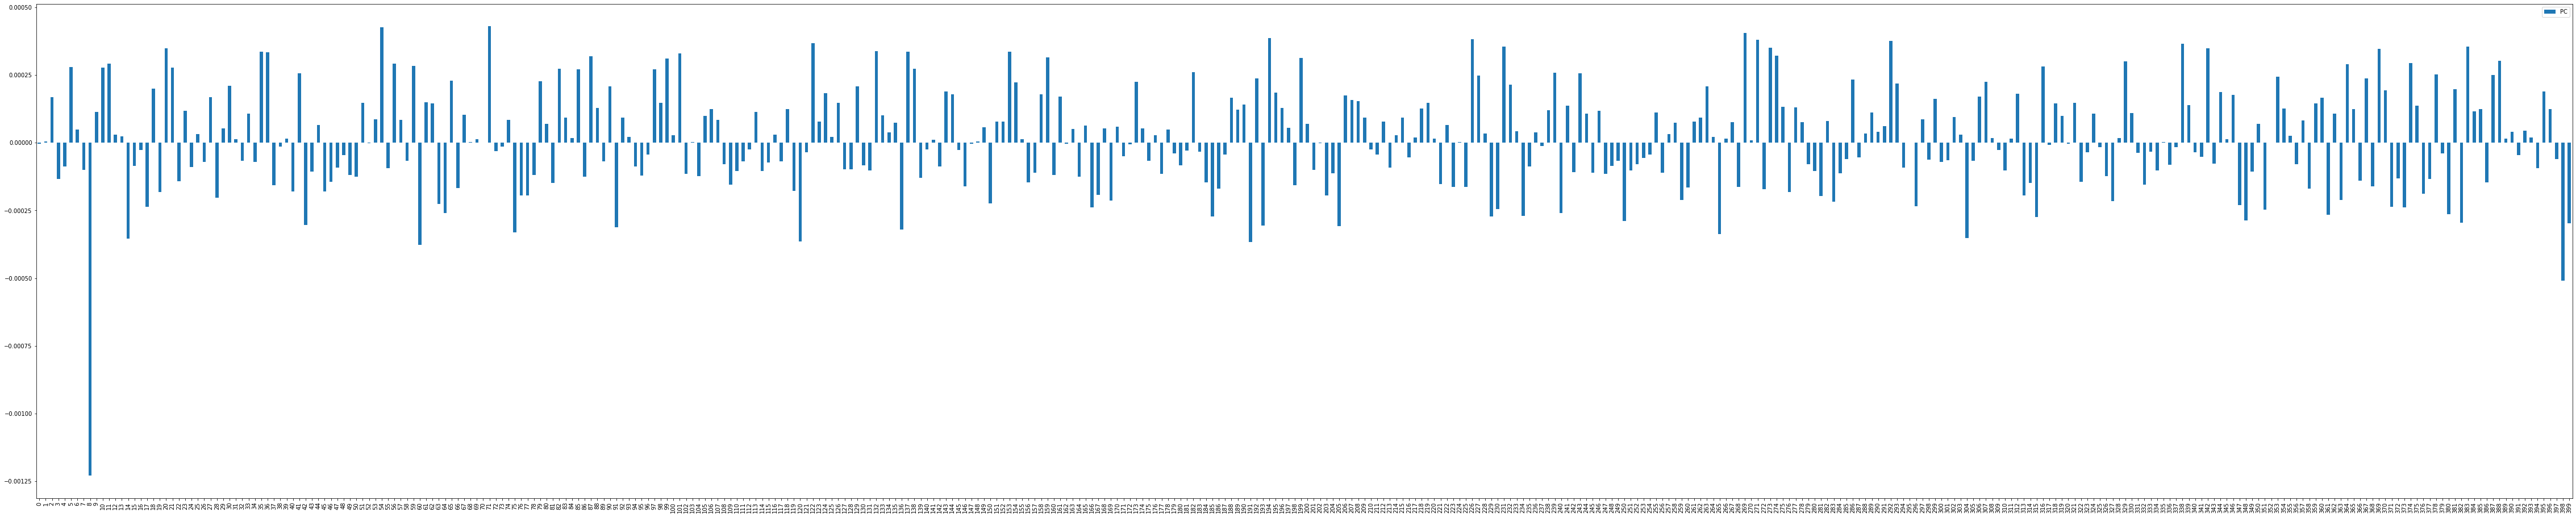

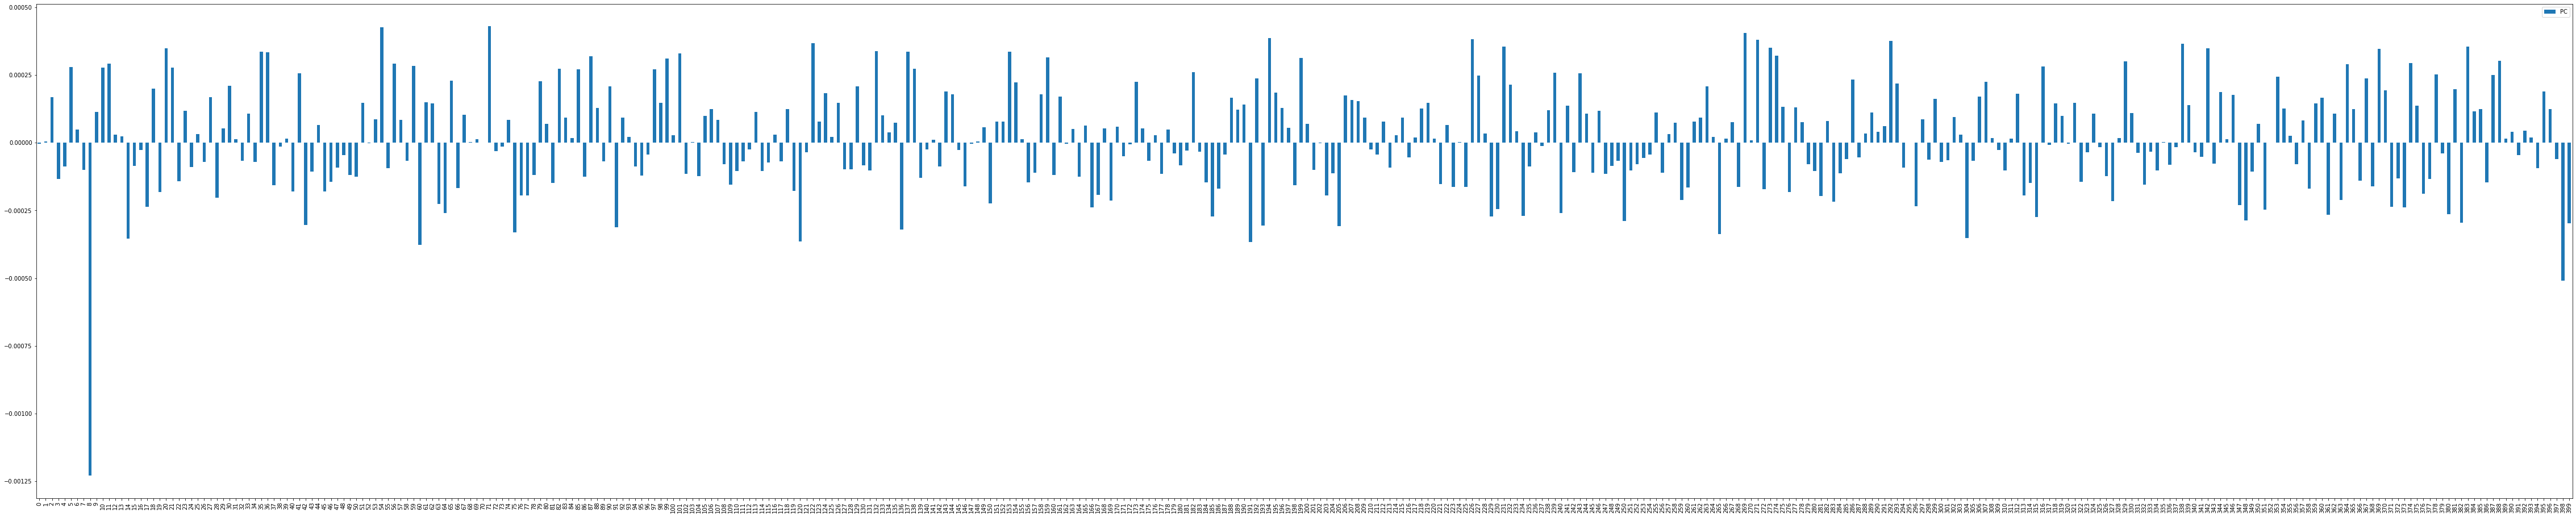

In [ ]:
#@title Normal_PC
pd.options.display.float_format = '{:,.8f}'.format
#reading csv
normal_pc=pd.read_csv("/content/drive/My Drive/Tese/Dados/atmeganormal.csv", sep=',',  header=None, names=["Tempo", "PC"],skiprows=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
tempo=normal_pc["Tempo"]
normal_pc=scipy.signal.savgol_filter(normal_pc['PC'].values, 953, 3)
normal_pc=pd.DataFrame(normal_pc)
normal_pc.columns=["PC"]
normal_pc["Tempo"]=tempo
#normal_pc.iloc[:5000,:].plot(figsize=(40,8),y="PC")


len_normal_pc = len(normal_pc.index)#number of samples

freq_normal_pc = 20e9 #sampling frequency 

freqinst_normal_pc = 4e6  #instruction frequency 

T_normal_pc = 1/freq_normal_pc #time period

Tinst_normal_pc= 1/freqinst_normal_pc #instruction time period


t=normal_pc["Tempo"].values
f=normal_pc["PC"].values

fhat=np.fft.fft(f,n=12500000)

f_downsample=np.fft.ifft(fhat,1000000)

normal_pc_resample=pd.DataFrame(f_downsample.real)

normal_pc_resample.columns=["PC"]


print(len(normal_pc_resample["PC"].index))


normal_pc_resample = normal_pc_resample.drop(normal_pc_resample[normal_pc_resample.index < 61].index)
normal_pc_resample.reset_index(drop=True, inplace=True)

normal_pc_resample.iloc[:200,:].plot(figsize=(80,16),y="PC")


normal_pc_resample = normal_pc_resample.drop(normal_pc_resample[normal_pc_resample.index > 820800].index)
normal_pc_resample.reset_index(drop=True, inplace=True)

normal_pcmean=normal_pc_resample.groupby(normal_pc_resample.index//100).mean()

offset=(normal_pcmean.iloc[:,0].idxmin(1))
print(offset)
normal_pcmean["Indice"]=pd.DataFrame(((normal_pcmean.index-offset)%1026).values)
normal_pcmean=pd.DataFrame.sort_values(normal_pcmean,"Indice",ignore_index=True)
normal_pcmean=pd.DataFrame(normal_pcmean).copy()
normal_pcmean_pc=pd.DataFrame(normal_pcmean).copy()
normal_pcmean_ir=pd.DataFrame(normal_pcmean).copy()
normal_pcmean_pc["PC"]=normal_pcmean_pc["PC"]-u_pc[0]

pc_index=0
for x in normal_pcmean.index:
  pc_index=(bin((x)^(x+1)).count('1'))%11
  normal_pcmean_ir.iloc[x,0]=normal_pcmean.iloc[x,0]-u_pc[0]

normal_pcmean.iloc[:400,:].plot.bar(figsize=(80,16),y="PC")
normal_pcmean_pc.iloc[:400,:].plot.bar(figsize=(80,16),y="PC")
normal_pcmean_ir.iloc[:400,:].plot.bar(figsize=(80,16),y="PC")
#scaler = MinMaxScaler()
#normal_pc_norm = scaler.fit_transform(normal_pcmean)
#normal_pcmean=pd.DataFrame(normal_pc_norm, index=normal_pcmean.index, columns=normal_pcmean.columns)

#normal_pcmean.iloc[:400,:].plot.bar(figsize=(80,16),y="PC")


[1.4377499821669392e-05, -8.512582608903633e-06, -6.153139278274109e-06, 3.5814432379946544e-06, 1.3524555221091545e-05, 1.2842034676205173e-05, -1.3627069827146718e-06, -4.538638867261845e-06, 1.9319092038010367e-05, 7.7020763120035e-06, 1.748503504640417e-05, 6.045795016146893e-06, 1.1038097036735784e-05, 1.115061412464992e-05, -1.1961230583567168e-06]
[0.0, -2.2890082430573028e-05, -2.05306390999435e-05, -1.0796056583674738e-05, -8.529446005778475e-07, -1.535465145464219e-06, -1.5740206804384064e-05, -1.8916138688931236e-05, 4.941592216340975e-06, -6.6754235096658925e-06, 3.1075352247347776e-06, -8.3317048055225e-06, -3.3394027849336087e-06, -3.226885697019472e-06, -1.557362288002611e-05]


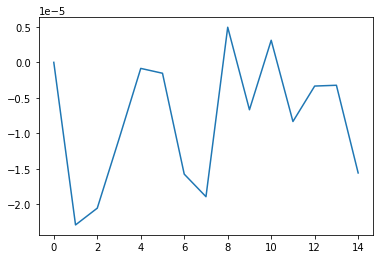

In [ ]:
#@title IR Signal Characterization
hdir = [0 for x in range(15)] 
hdir=hd_ir(1026,15,2)

sig_ir=irmeanir.iloc[0:8208,:]

u_ir = [0 for x in range(15)] 
u_ir=irbackground_calc(sig_ir, hdir, 8, 1026, 15)
print(u_ir)

#u_ir=wp_sub(u_pc, u_ir, 15)

wp_ir=[0 for x in range(15)]
wp_ir=irwp_calculator(u_ir,15)
print(wp_ir)


In [ ]:
#@title Matrix PC
wp_pc=np.array(wp_pc)
wp_ir=np.array(wp_ir)
wp_sig=np.array(wp_sig)

Amps = [[0 for x in range(8208)] for y in range(3)]


w, h = 2, 1;
Matrix_wp = np.ones((1, 3))
Amplitudes=np.ones((3,1))
signal_wo_background = np.ones((1, 1))

for x in range(8208) :
  Matrix_wp[0][0]=wp_pc[int(x%11)]
  Matrix_wp[0][1]=wp_ir[int(x%15)]
  Matrix_wp[0][2]=wp_sig[int(x%1026)]
  signal_wo_background[0][0]=irmeanpc.iloc[x,0]
  #print(scipy.linalg.lstsq(signal_wo_background,Matrix_wp)[0])
  Amplitudes=(scipy.linalg.lstsq(Matrix_wp.T.dot(Matrix_wp), Matrix_wp.T)[0]).dot(signal_wo_background)
  Amps[0][x]=np.sqrt(np.mean(Amplitudes[0][0]**2))
  Amps[1][x]=np.sqrt(np.mean(Amplitudes[1][0]**2))
  Amps[2][x]=np.sqrt(np.mean(Amplitudes[2][0]**2))


  #print(scipy.linalg.lstsq(Matrix_wp.T.dot(Matrix_wp), Matrix_wp.T)[0].dot(signal_wo_background))
  #print(scipy.linalg.lstsq(Matrix_wp.T.dot(Matrix_wp), Matrix_wp.T)[0].dot(signal_wo_background).shape)

Amplis=pd.DataFrame(Amps[0])
Amplis.columns=["P_i"]
Amplis["I_i"]=pd.DataFrame(Amps[1])
Amplis["X_i"]=pd.DataFrame(Amps[2])
plt.plot(Amplis["X_i"])
plt.show()

plt.plot(Amplis["P_i"])
plt.show()

plt.plot(Amplis["I_i"])


plt.show()

#[S-u]/[Wp | Wx]

NameError: ignored

In [ ]:
#@title No
features2["P_i"]=Amplis["P_i"]
#features2["I_i"]=Amplis["I_i"]
features2["X_i"]=Amplis["X_i"]

train=features2

states={1:1, 2:2, 3:14,4:13,5:6, 6:7, 7:8, 8:9,9:10,10:11,11:12, 12:3, 13:4, 14:5,15:15}



ir=0
#for x in train.index:
 # if (x%2==0 and x>=1):
 #   ir=ir+1
 # train.loc[x,"HDIR"]=ir%15
pc_i=0
pc_i_total=[]
#for x in train.index:
  #if (pc_i>1025):
   #   pc_i=0
  #pc_i_total.append(bin((pc_i)^(pc_i+1)).count('1'))
train["HDPC"]=sig_x_pc["HDPC"]
  #pc_i=pc_i+1
train_x=pd.DataFrame(train["X_i"])
train_x["P_i"]=pd.DataFrame(train["P_i"])
#train_y=pd.DataFrame(train["HDIR"], dtype='int32')
print(train["HDPC"])

             IR  Indice
0    0.00206376       0
1    0.00249313       0
2    0.00234082       0
3    0.00256274       0
4    0.00240645       0
...         ...     ...
4099 0.00239896     512
4100 0.00196843     512
4101 0.00265023     512
4102 0.00201776     512
4103 0.00214174     512

[4104 rows x 2 columns]
0
1
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
             PC
0    0.00224856
1    0.00203102
2    0.00220726
3    0.00222051
4    0.00213628
...         ...
4099 0.00227463
4100 0.00216848
4101 0.00240797
4102 0.00215260
4103 0.00215862

[4104 rows x 1 columns]
              IR  Indice
0    -0.00018981       0
1     0.00023956       0
2     0.00008726       0
3     0.00030917       0
4     0.00015288       0
...          ...     ...
4099  0.00014539     512
4100 -0.00028514     512
4101  0.00039666     512
4102 -0.00023581     512
4103 -0.00011183     512

[4104 rows x 2 columns]
             IR  Indice
0    0.00206376       0
1    0.00249313       0
2    0.00234082       0
3    0.

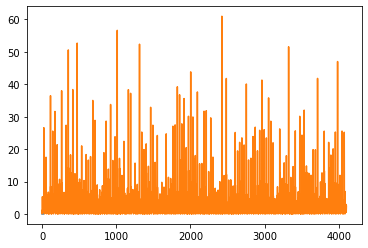

In [ ]:
#@title Matrix PC

sig_x=irmean.iloc[0:4104,:]
sig_xpc=pcmean.iloc[0:4104,:]
sig_xir=irmeanir.iloc[0:4104,:]

#sig_x.index=sig_x.index-2052

hsig= [0 for x in range(17)] 
hsig=hd_sig(1026,17)





u_pc=np.array( u_pc)
wp_pc=np.array( wp_pc)
wp_ir=np.array( wp_ir)


#w, h = 2, 1;
#Matrix_wp = np.ones((1, 2))
#Amplitudes=np.ones((2,1))
#signal_wo_background = np.ones((1, 1))
#sig_x_w=sig_x.values
#features2=s_calculator(sig_x, hsig, 1, 1026, 11)[0]
#i=(s_calculator(sig_x, hsig, 1, 1026, 11)[0]["HDPC"]).values

Amps = [[0 for x in range(4104)] for y in range(3)]


w, h = 2, 1;
Matrix_wp = np.ones((1, 3))
Amplitudes=np.ones((3,1))
signal_wo_background = np.ones((1, 1))
sig_x_w=sig_x.values
features2=s_calculator(sig_x, hsig, 1, 4104, 17)
#sig_x2=wp_sub(u_pc,features2["PC"], 1026)
#print(sig_x2)

u_sig = [0 for x in range(17)] 
u_sig=background_calc(pd.DataFrame(sig_x), hsig, 4, 1026, 17)

wp_sig=[0 for x in range(17)]
wp_sig=wp_calculator(u_sig,17)

wp_sig=np.array( wp_sig)

i=(s_calculator(sig_xpc, hsig, 1, 4104, 11).loc[:, "HDPC"]).values
i2=(s_calculator(sig_xir, hsig, 1, 4104, 15).loc[:, "HDIR"]).values
i3=(s_calculator(sig_x, hsig, 1, 4104, 17).loc[:, "HDIR"]).values

#features2["PC"]=sig_x2


for x in features2.index :
  Matrix_wp[0][0]=wp_pc[(int(i[x])-1)]
  Matrix_wp[0][1]=wp_sig[int(i3[x])-1]
  Matrix_wp[0][2]=wp_ir[(int(i2[x]))]
  signal_wo_background[0][0]=features2["IR"][x]-u_pc[0]
  #print(scipy.linalg.lstsq(signal_wo_background,Matrix_wp)[0])
  Amplitudes=(scipy.linalg.lstsq(Matrix_wp.T.dot(Matrix_wp), Matrix_wp.T)[0]).dot(signal_wo_background)
  Amps[0][x]=np.sqrt(np.mean(Amplitudes[0][0]**2))
  Amps[1][x]=np.sqrt(np.mean(Amplitudes[1][0]**2))
  Amps[2][x]=np.sqrt(np.mean(Amplitudes[2][0]**2))


  #print(scipy.linalg.lstsq(Matrix_wp.T.dot(Matrix_wp), Matrix_wp.T)[0].dot(signal_wo_background))
  #print(scipy.linalg.lstsq(Matrix_wp.T.dot(Matrix_wp), Matrix_wp.T)[0].dot(signal_wo_background).shape)

Amplis=pd.DataFrame(Amps[0])
Amplis.columns=["P_i"]
Amplis["X_i"]=pd.DataFrame(Amps[1])
Amplis["I_i"]=pd.DataFrame(Amps[2])
plt.plot(Amplis["X_i"])
plt.show()

#[S-u]/[Wp | Wx]

In [ ]:
features2["X_i"]=Amplis["X_i"]
features2["P_i"]=Amplis["P_i"]
train_pc=features2
#features2["X_i_ir"]=Amplis["X_i_ir"]
features2["I_i"]=Amplis["I_i"]
train_ir=features2
train=train_pc
#train["X_i_ir"]=train_ir["X_i_ir"]
train["I_i"]=train_ir["I_i"]
train["HDIR"]=train_pc["HDIR"]


train_x=pd.DataFrame(train["P_i"])
train_x["I_i"]=pd.DataFrame(train["I_i"])
#train_x["X_i"]=pd.DataFrame(train["X_i"])
train_y=pd.DataFrame(train["HDIR"], dtype='int32')
print(train["HDIR"])
print(train["I_i"])



0       0.00000000
1       0.00000000
2       1.00000000
3       1.00000000
4       2.00000000
           ...    
4099    9.00000000
4100   10.00000000
4101   10.00000000
4102   11.00000000
4103   11.00000000
Name: HDIR, Length: 4104, dtype: float64
0       0.00000000
1       0.00000000
2      53.93905308
3       6.17997443
4       3.76235949
           ...    
4099    0.23085539
4100    0.02414606
4101    0.00769243
4102    0.15080218
4103    0.19848457
Name: I_i, Length: 4104, dtype: float64


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


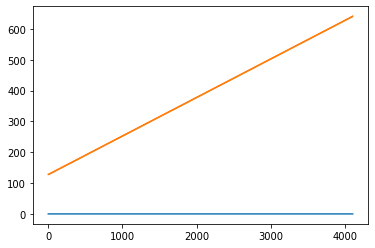

<Figure size 1440x720 with 0 Axes>

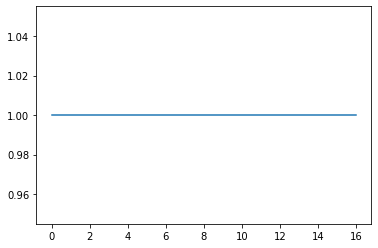

<Figure size 1440x720 with 0 Axes>

              PC  Indice
0     0.00002124     128
1    -0.00035600     128
2    -0.00006595     128
3    -0.00012047     128
4     0.00019755     128
...          ...     ...
4099  0.00015474     640
4100  0.00001972     640
4101 -0.00039543     640
4102  0.00029793     640
4103 -0.00023256     641

[4104 rows x 2 columns]


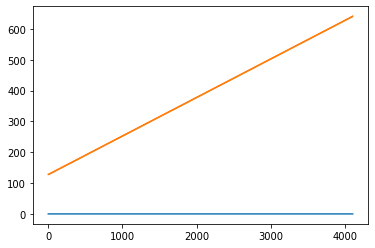

<Figure size 1440x720 with 0 Axes>

0
1
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
             PC  Indice
0    0.00227481     128
1    0.00189756     128
2    0.00218762     128
3    0.00213309     128
4    0.00245112     128
...         ...     ...
4099 0.00240830     640
4100 0.00227328     640
4101 0.00185813     640
4102 0.00255150     640
4103 0.00202101     641

[4104 rows x 2 columns]
              PC  Indice
0     0.00002124     128
1    -0.00035600     128
2    -0.00006595     128
3    -0.00012047     128
4     0.00019755     128
...          ...     ...
4099  0.00015474     640
4100  0.00001972     640
4101 -0.00039543     640
4102  0.00029793     640
4103 -0.00023256     641

[4104 rows x 2 columns]
              PC  Indice
0     0.00002124     128
1    -0.00035600     128
2    -0.00006595     128
3    -0.00012047     128
4     0.00019755     128
...          ...     ...
4099  0.00015474     640
4100  0.00001972     640
4101 -0.00039543     640
4102  0.00029793     640
4103 -0.00023256     641

[4104 rows x 2 colu

<Figure size 1440x720 with 0 Axes>

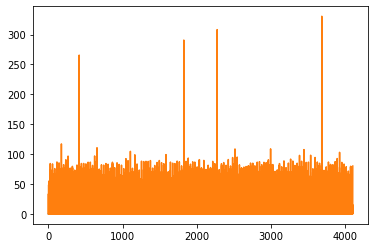

<Figure size 1440x720 with 0 Axes>

In [ ]:
#@title Matrix Sinal PC

sig_x_2=normal_pcmean_pc.iloc[1026:5130,:].copy()
sig_x_2.index=sig_x_2.index-1026

sig_x_2_ir=normal_pcmean_ir.iloc[1026:5130,:].copy()
sig_x_2_ir.index=sig_x_2_ir.index-1026

sig_x_2_pc=normal_pcmean.iloc[1026:5130,:].copy()
sig_x_2_pc.index=sig_x_2_pc.index-1026

hsig_2= [0 for x in range(17)] 
hsig_2=hd_sig(1026,17)
print(hsig_2)
u_pc_2=np.array( u_pc)
wp_pc_2=np.array( wp_pc)
wp_ir_2=np.array( wp_ir)




#w, h = 2, 1;
#Matrix_wp = np.ones((1, 2))
#Amplitudes=np.ones((2,1))
#signal_wo_background = np.ones((1, 1))
#sig_x_w=sig_x.values
#features2=s_calculator(sig_x, hsig, 1, 1026, 11)[0]
#i=(s_calculator(sig_x, hsig, 1, 1026, 11)[0]["HDPC"]).values

Amps_2 = [[0 for x in range(4104)] for y in range(3)]


w_2, h_2 = 3, 1;
Matrix_wp_2 = np.ones((1, 3))
Amplitudes_2=np.ones((3,1))
signal_wo_background_2 = np.ones((1, 1))
sig_x_w_2=sig_x_2.values
plt.plot(sig_x_2)
plt.figure(figsize=(20,10))
plt.show()
plt.plot(hsig_2)
plt.figure(figsize=(20,10))
plt.show()
features2_2=s_calculator(sig_x_2, hsig_2, 1, 4104, 17)
#sig_x2=wp_sub(u_pc,features2_2["PC"], 6156)

plt.plot(sig_x_w_2)
plt.figure(figsize=(20,10))
plt.show()

u_sig_2 = [0 for x in range(17)] 
u_sig_2=background_calc(pd.DataFrame(sig_x_2), hsig_2, 4, 1026, 17)

wp_sig_2=[0 for x in range(17)]
wp_sig_2=wp_calculator(u_sig_2,17)

wp_sig_2=np.array( wp_sig_2)

i_2=(s_calculator(pd.DataFrame(sig_x_2_pc), hsig_2, 1, 4104, 11).loc[:, "HDPC"]).values
i_3=(s_calculator(pd.DataFrame(sig_x_2_ir), hsig_2, 1, 4104, 15).loc[:, "HDIR"]).values
i_4=(s_calculator(pd.DataFrame(sig_x_2), hsig_2, 1, 4104, 17).loc[:, "HDIR"]).values

#features2_2["PC"]=sig_x2


for x in features2_2.index :

  Matrix_wp_2[0][0]=wp_pc_2[(int(i_2[x])-1)]
  Matrix_wp_2[0][1]=wp_sig_2[int(i_4[x])-1]
  Matrix_wp_2[0][2]=wp_ir_2[int(i_3[x])]
  signal_wo_background_2[0][0]=features2_2["PC"][x]-u_pc_2[0]
  #print(scipy.linalg.lstsq(signal_wo_background,Matrix_wp)[0])
  Amplitudes_2=(scipy.linalg.lstsq(Matrix_wp_2.T.dot(Matrix_wp_2), Matrix_wp_2.T)[0]).dot(signal_wo_background_2)
  Amps_2[0][x]=np.sqrt(np.mean(Amplitudes_2[0][0]**2))
  Amps_2[1][x]=np.sqrt(np.mean(Amplitudes_2[1][0]**2))
  Amps_2[2][x]=np.sqrt(np.mean(Amplitudes_2[2][0]**2))

  #print(Matrix_wp_2[0][0])
  #print(Matrix_wp_2[0][2])
  #print(Matrix_wp_2[0][1])
  #print(signal_wo_background_2[0][0])
  #print(Amplis["I_i"])
  #print("PC:",int(i_2[x])-1)
  #print("IR",int(i_3[x])-1)

  #print(Amplis["P_i"])#Amplitudes_2[1][0]
  #print(scipy.linalg.lstsq(Matrix_wp.T.dot(Matrix_wp), Matrix_wp.T)[0].dot(signal_wo_background))
  #print(scipy.linalg.lstsq(Matrix_wp.T.dot(Matrix_wp), Matrix_wp.T)[0].dot(signal_wo_background).shape)

Amplis_2=pd.DataFrame(Amps_2[0])
Amplis_2.columns=["P_i"]
Amplis_2["X_i"]=pd.DataFrame(Amps_2[1])
Amplis_2["I_i"]=pd.DataFrame(Amps_2[2])


plt.plot(Amplis_2["P_i"])
plt.figure(figsize=(20,10))

#[S-u]/[Wp | Wx]

In [ ]:
#features2_2["X_i_ir"]=Amplis_2["X_i_ir"]
features2_2["P_i"]=Amplis_2["P_i"]
features2_2["X_i"]=Amplis_2["X_i"]
test_pc=features2_2
features2_2["I_i"]=Amplis_2["I_i"]
test=features2_2
test["X_i"]=test_pc["X_i"]
test["P_i"]=test_pc["P_i"]

states={1:1, 2:2, 3:14,4:13,5:6, 6:7, 7:8, 8:9,9:10,10:11,11:12, 12:3, 13:4, 14:5,15:15}



ir=21
for x in test.index:
  test.loc[x,"HDIR"]=states.get((x%15)+1)-1



test_x=pd.DataFrame(test["P_i"])
test_x["I_i"]=pd.DataFrame(test["I_i"])
#test_x["X_i"]=pd.DataFrame(test["X_i"])

test_y=pd.DataFrame(test["HDIR"], dtype='int32')
print(test_y)


      HDIR
0        0
1        1
2       13
3       12
4        5
...    ...
4099     5
4100     6
4101     7
4102     8
4103     9

[4104 rows x 1 columns]


In [ ]:
train, test = train_test_split(test, test_size=0.5)

#PC
train_x_pc=pd.DataFrame(train['P_i'])
train_y_pc=pd.DataFrame(train['HDPC'])
test_x_pc=pd.DataFrame(test['P_i'])
test_y_pc=pd.DataFrame(test['HDPC'])

#IR
train_x_ir=pd.DataFrame(train['P_i'])
train_x_ir['I_i']=pd.DataFrame(train['I_i'])
train_y_ir=pd.DataFrame(train['HDIR'])
test_x_ir=pd.DataFrame(test['P_i'])
test_x_ir['I_i']=pd.DataFrame(test['I_i'])
test_y_ir=pd.DataFrame(test['HDIR'])

In [ ]:
train_2=pd.DataFrame(train['P_i'])
train_2['I_i']=pd.DataFrame(train['I_i'])
train_2['X_i']=pd.DataFrame(train['X_i'])
train_2['HDPC']=pd.DataFrame(train['HDPC'])
train_2['HDIR']=pd.DataFrame(train['HDIR'])

test_2=pd.DataFrame(test['P_i'])
test_2['I_i']=pd.DataFrame(test['I_i'])
test_2['X_i']=pd.DataFrame(test['X_i'])
test_2['HDPC']=pd.DataFrame(test['HDPC'])
test_2['HDIR']=pd.DataFrame(test['HDIR'])

train_2.to_csv("/content/drive/My Drive/Tese/Dados/train.csv")

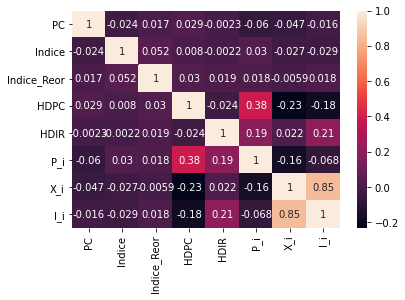

In [ ]:
#@title Divisão Datasets


# Class count

sns.heatmap(test.corr(),annot=True)


The accuracy of the DT is:  0.685672514619883


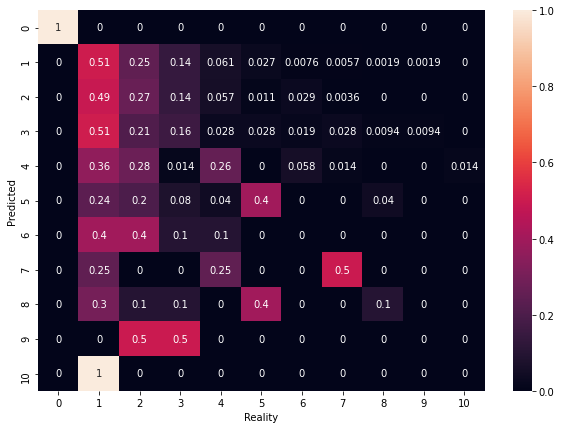

In [ ]:
#@title Decision Tree for PC
model = DecisionTreeClassifier(class_weight="balanced")
model.fit(train_x_pc, train_y_pc)

prediction = model.predict(test_x_pc)
print('The accuracy of the DT is: ', metrics.accuracy_score(prediction, test_y_pc))
plt.figure(figsize=(10,7))
test_2['Predicted_PC']=prediction
C=metrics.confusion_matrix(prediction,test_y_pc)
sns.heatmap(C.astype('float') / (C.sum(axis=1)+0.0000001)[:, np.newaxis], annot=True)
plt.ylabel("Predicted")
plt.xlabel("Reality")
test_2.to_csv("/content/drive/My Drive/Tese/Dados/test.csv")

The accuracy of the DT is:  0.895224171539961


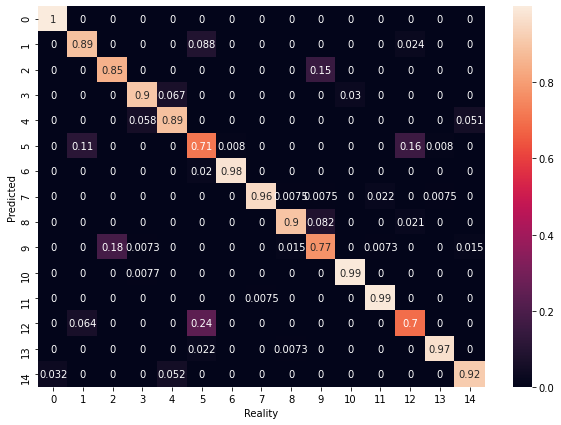

In [ ]:
#@title Decision Tree for IR
model = DecisionTreeClassifier(class_weight="balanced")
model.fit(train_x_ir, train_y_ir)

prediction = model.predict(test_x_ir)
print('The accuracy of the DT is: ', metrics.accuracy_score(prediction, test_y_ir))
plt.figure(figsize=(10,7))
test_2['Predicted_IR']=prediction
C=metrics.confusion_matrix(prediction,test_y_ir)
sns.heatmap(C.astype('float') / (C.sum(axis=1)+0.0000001)[:, np.newaxis], annot=True)
plt.ylabel("Predicted")
plt.xlabel("Reality")
test_2.to_csv("/content/drive/My Drive/Tese/Dados/test.csv")

The accuracy of the LR is:  0.73635477582846
[1015  911   64   30   22    7    2    0    1    0    0]


Text(69.0, 0.5, 'Reality')

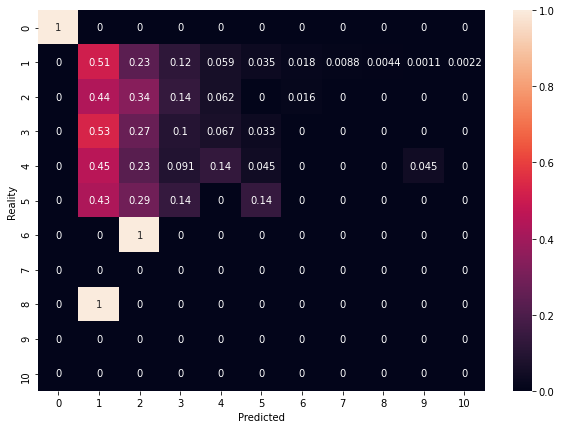

In [ ]:
#@title SVC
model = SVC(kernel="rbf", C=1, gamma=1e5, class_weight="balanced", probability=True)
model.fit(train_x, train_y.values.ravel())
prediction = model.predict(test_x)
print('The accuracy of the LR is: ', metrics.accuracy_score(prediction, test_y))
plt.figure(figsize=(10,7))
C=metrics.confusion_matrix(prediction,test_y)
print((C.sum(axis=1)))
sns.heatmap(C.astype('float') / (C.sum(axis=1)+0.0000001)[:, np.newaxis], annot=True)
plt.xlabel("Predicted")
plt.ylabel("Reality")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


The accuracy of the KN is:  0.7353801169590644


Text(69.0, 0.5, 'Reality')

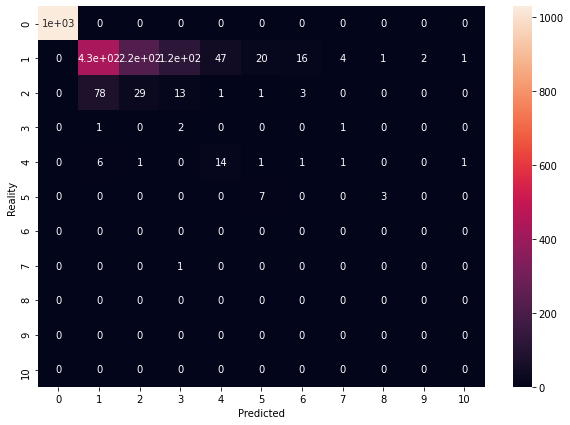

In [ ]:
#@title KNeighboors
model = KNeighborsClassifier(n_neighbors=10)

model.fit(train_x, train_y)

prediction = model.predict(test_x)
print('The accuracy of the KN is: ', metrics.accuracy_score(prediction, test_y))
plt.figure(figsize=(10,7))
sns.heatmap(metrics.confusion_matrix(prediction,test_y), annot=True)
plt.xlabel("Predicted")
plt.ylabel("Reality")